<a href="https://colab.research.google.com/github/BassamTar99/StockPrediction/blob/LSTM_Model/Automated_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#@title Cell 1: Install Dependencies
!pip install yfinance matplotlib tensorflow keras-tuner


In [17]:
# Cell 2: Imports & Reproducibility
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from kerastuner.tuners import RandomSearch

# Fix seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [18]:
# Cell 3: Prompt for Ticker & Download Data
ticker = input("Enter the stock ticker (e.g. AAPL, TSLA): ").upper().strip()
start  = "2010-01-01"
end    = "2025-04-23"

df = yf.download(ticker, start=start, end=end)
if df.empty:
    raise ValueError(f"No data found for ticker '{ticker}'. Please rerun and try another.")

print(f"Downloaded {len(df)} rows for {ticker}")
df.head()


Enter the stock ticker (e.g. AAPL, TSLA): AAPL


[*********************100%***********************]  1 of 1 completed

Downloaded 3849 rows for AAPL


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.440332,6.455078,6.391279,6.422878,493729600
2010-01-05,6.451466,6.487879,6.417460,6.458087,601904800
2010-01-06,6.348846,6.477045,6.342225,6.451465,552160000
2010-01-07,6.337109,6.379843,6.291066,6.372319,477131200
2010-01-08,6.379241,6.379843,6.291368,6.328683,447610800


In [19]:
# Cell 4: Scale 'Close' & Create Sequences
# 1) Extract Close
close_series = df['Close'].values.reshape(-1,1)

# 2) Scale to [0,1]
scaler     = MinMaxScaler(feature_range=(0,1))
scaled     = scaler.fit_transform(close_series).flatten()
data_min   = scaler.data_min_[0]
data_max   = scaler.data_max_[0]

# 3) Sequence creation
SEQ_LEN = 30
X, y = [], []
for i in range(SEQ_LEN, len(scaled)):
    X.append(scaled[i-SEQ_LEN:i])
    y.append(scaled[i])
X = np.array(X).reshape(-1, SEQ_LEN, 1)
y = np.array(y)
print("X shape:", X.shape, "y shape:", y.shape)


X shape: (3819, 30, 1) y shape: (3819,)


In [20]:
# Cell 5: 80/10/10 Train/Val/Test Split
n        = len(X)
n_train  = int(0.8 * n)
n_val    = int(0.1 * n)

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (3055, 30, 1) Val: (381, 30, 1) Test: (383, 30, 1)


In [22]:
# Cell 6: Hyperparameter Tuning (reset per ticker) + fixed LSTM stacking + single optimizer
import shutil
import tensorflow as tf
from kerastuner.tuners import RandomSearch

# 1) Clear previous Keras state
tf.keras.backend.clear_session()

# 2) Remove old tuner directory
shutil.rmtree('tuner_dir', ignore_errors=True)

# 3) Define model builder: 2-layer LSTM, first returns sequences, always RMSprop
def build_model(hp):
    units = hp.Int('units', 32, 128, step=16)
    drop  = hp.Float('dropout', .1, .5, step=.1)
    recdp = hp.Float('rec_dropout', .1, .5, step=.1)
    post  = hp.Float('post_dropout', .1, .5, step=.1)
    lr    = hp.Float('lr', 1e-4, 1e-2, sampling='log')

    model = Sequential([
        # first LSTM must return sequences for stacking
        LSTM(units,
             return_sequences=True,
             input_shape=(SEQ_LEN,1),
             dropout=drop,
             recurrent_dropout=recdp),
        Dropout(post),

        # second LSTM (no return_sequences)
        LSTM(units,
             return_sequences=False,
             dropout=drop,
             recurrent_dropout=recdp),
        Dropout(post),

        Dense(1, activation='linear')
    ])

    # always use RMSprop
    model.compile(
        optimizer=RMSprop(learning_rate=lr),
        loss='mse'
    )
    return model

# 4) Instantiate tuner (overwrite old trials)
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name=f'{ticker}_tuning',
    overwrite=True
)

# 5) Run hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

# 6) Display best HPs
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
for p in ['units','dropout','rec_dropout','post_dropout','lr']:
    print(f" • {p}: {best_hps.get(p)}")


Trial 10 Complete [00h 01m 15s]
val_loss: 0.0906965583562851

Best val_loss So Far: 0.0011070731561630964
Total elapsed time: 00h 14m 20s
Best Hyperparameters:
 • units: 32
 • dropout: 0.1
 • rec_dropout: 0.30000000000000004
 • post_dropout: 0.1
 • lr: 0.0070178386117091705


In [24]:
# Cell 7: Train Final Model with Best Hyperparams
hp = best_hps
model = build_model(hp)  # rebuild with best_hps

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/50
96/96 - 15s - 159ms/step - loss: 0.0084 - val_loss: 7.0239e-04 - learning_rate: 0.0070
Epoch 2/50
96/96 - 5s - 50ms/step - loss: 0.0058 - val_loss: 7.3680e-04 - learning_rate: 0.0070
Epoch 3/50
96/96 - 6s - 67ms/step - loss: 0.0061 - val_loss: 0.0095 - learning_rate: 0.0070
Epoch 4/50
96/96 - 5s - 50ms/step - loss: 0.0065 - val_loss: 0.0034 - learning_rate: 0.0070
Epoch 5/50
96/96 - 6s - 58ms/step - loss: 0.0048 - val_loss: 0.0030 - learning_rate: 0.0035
Epoch 6/50
96/96 - 10s - 103ms/step - loss: 0.0046 - val_loss: 0.0094 - learning_rate: 0.0035
Epoch 7/50
96/96 - 6s - 67ms/step - loss: 0.0047 - val_loss: 0.0074 - learning_rate: 0.0035
Epoch 8/50
96/96 - 9s - 93ms/step - loss: 0.0044 - val_loss: 0.0023 - learning_rate: 0.0018
Epoch 9/50
96/96 - 10s - 101ms/step - loss: 0.0044 - val_loss: 0.0056 - learning_rate: 0.0018
Epoch 10/50
96/96 - 7s - 68ms/step - loss: 0.0044 - val_loss: 0.0101 - learning_rate: 0.0018
Epoch 11/50
96/96 - 5s - 49ms/step - loss: 0.0044 - val_loss: 0.0

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step
Test MSE: 56.4680


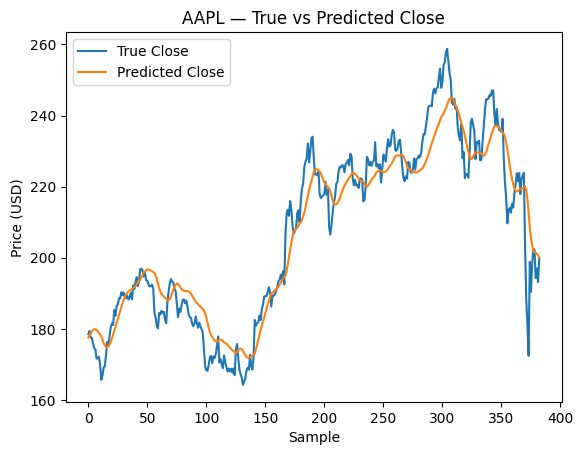

In [25]:
# Cell 8: Evaluate on Test Set & Plot
# Predict (scaled)
pred_scaled = model.predict(X_test).flatten()

# Inverse scale
true = y_test * (data_max - data_min) + data_min
pred = pred_scaled * (data_max - data_min) + data_min

# Compute & print MSE
mse = mean_squared_error(true, pred)
print(f"Test MSE: {mse:.4f}")

# Plot
plt.figure()
plt.plot(true, label='True Close')
plt.plot(pred, label='Predicted Close')
plt.title(f'{ticker} — True vs Predicted Close')
plt.xlabel('Sample')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [26]:
# Cell 9: N-Day-Ahead Recursive Forecast
n_days = int(input("Enter number of days to forecast: "))
forecast_seq = scaled[-SEQ_LEN:].copy()
forecasts = []

for _ in range(n_days):
    nxt = model.predict(forecast_seq.reshape(1,SEQ_LEN,1)).flatten()[0]
    forecasts.append(nxt)
    forecast_seq = np.append(forecast_seq[1:], nxt)

# Inverse scale & display
forecasts_uv = [f*(data_max-data_min)+data_min for f in forecasts]
for i, val in enumerate(forecasts_uv, start=1):
    print(f"Day +{i} forecast: ${val:.2f}")


Enter number of days to forecast: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Day +1 forecast: $199.97
Day +2 forecast: $200.05
Day +3 forecast: $200.23


In [27]:
# Cell 10: Save Model & Scaler
model.save('lstm_model.keras')
import joblib, os
os.makedirs('models', exist_ok=True)
joblib.dump(scaler, 'models/close_scaler.save')
print("Saved model to lstm_model.keras and scaler to models/close_scaler.save")


Saved model to lstm_model.keras and scaler to models/close_scaler.save
